In [1]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("zlatan599/mushroom1")

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

In [ ]:
from keras import Sequential, Input, layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [3]:
train = pd.read_csv('/kaggle/input/mushroom1/train.csv')
test = pd.read_csv('/kaggle/input/mushroom1/test.csv')
val = pd.read_csv('/kaggle/input/mushroom1/val.csv')

update paths in the csv

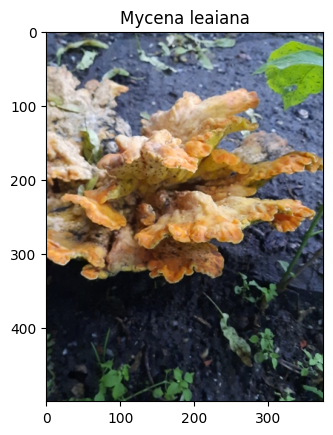

In [4]:
BASE_PATH = "/kaggle/input/mushroom1/merged_dataset"


# Replace Kaggle path with Colab base path
train["image_path"] = train["image_path"].str.replace(
    "/kaggle/working/merged_dataset", BASE_PATH
)
test["image_path"] = test["image_path"].str.replace(
    "/kaggle/working/merged_dataset", BASE_PATH
)
val["image_path"] = val["image_path"].str.replace(
    "/kaggle/working/merged_dataset", BASE_PATH
)


img_path = train["image_path"].iloc[50]

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.title(train["label"].iloc[5])
plt.show()

check images sizes

In [5]:
shapes = []
for path in train["image_path"].sample(500):
    with Image.open(path) as img:
        shapes.append(img.size)
sizes = pd.Series(shapes)
print(sizes.value_counts().head(15))

(640, 480)    106
(375, 500)     85
(500, 375)     65
(500, 333)     38
(480, 640)     18
(281, 500)     12
(640, 426)      8
(640, 360)      8
(333, 500)      7
(640, 427)      6
(360, 640)      6
(500, 281)      6
(500, 500)      5
(225, 500)      4
(640, 425)      4
Name: count, dtype: int64


Find duplicates inside train df and show the first few duplicates


In [6]:
dup_paths = train["image_path"][train["image_path"].duplicated()]
print("Number of duplicate image paths in train:", dup_paths.shape[0])
print(dup_paths.head(10))

Number of duplicate image paths in train: 616662
72858    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72859    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72860    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72861    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72862    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72863    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72864    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72865    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72866    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72867    /kaggle/input/mushroom1/merged_dataset/Agaricu...
Name: image_path, dtype: object


### drop duplicates

In [7]:
print("Before removing duplicates:", train.shape)
train_df_unique = train.drop_duplicates(subset="image_path", keep="first").reset_index(drop=True)
print("After  removing duplicates:", train_df_unique.shape)

Before removing duplicates: (689520, 2)
After  removing duplicates: (72858, 2)


In [8]:
print("Before removing duplicates:", test.shape)
test_df_unique = test.drop_duplicates(subset="image_path", keep="first").reset_index(drop=True)
print("After  removing duplicates:", test_df_unique.shape)

Before removing duplicates: (15614, 2)
After  removing duplicates: (15614, 2)


In [9]:
print("Before removing duplicates:", val.shape)
val_df_unique = val.drop_duplicates(subset="image_path", keep="first").reset_index(drop=True)
print("After  removing duplicates:", val_df_unique.shape)

Before removing duplicates: (15616, 2)
After  removing duplicates: (15616, 2)


### Count how many images per species

In [11]:
train_counts = train["label"].value_counts()

print("Number of species in train:", train_counts.shape[0])
print("\nTop 10 most common species:\n", train_counts.head(10))
print("\nBottom 10 least common species:\n", train_counts.tail(10))

Number of species in train: 169

Top 10 most common species:
 label
Lycoperdon perlatum            4080
Chlorociboria aeruginascens    4080
Amanita muscaria               4080
Xanthoria parietina            4080
Coprinellus micaceus           4080
Mycena leaiana                 4080
Suillus luteus                 4080
Gyromitra gigas                4080
Laetiporus sulphureus          4080
Fomitopsis pinicola            4080
Name: count, dtype: int64

Bottom 10 least common species:
 label
Tylopilus rubrobrunneus      4080
Fomitopsis mounceae          4080
Stereum hirsutum             4080
Peltigera aphthosa           4080
Cantharellus cinnabarinus    4080
Agaricus augustus            4080
Mutinus ravenelii            4080
Trametes betulina            4080
Gymnopilus luteofolius       4080
Coprinopsis atramentaria     4080
Name: count, dtype: int64

Stats on class counts:
count     169.0
mean     4080.0
std         0.0
min      4080.0
25%      4080.0
50%      4080.0
75%      4080.0
max 

### data preprocessing

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator:class from tensorflow.keras.preprocessing.image to automatically rescale, augment, and normalize image data and efficiently load batches of images from dataframe during training.

In [13]:
datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=True
)

Found 72858 validated image filenames belonging to 169 classes.


In [15]:
val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 15616 validated image filenames belonging to 169 classes.


In [16]:
test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 15614 validated image filenames belonging to 169 classes.


In [16]:
num_classes = len(train_gen.class_indices)

### baseline model

In [19]:
model = Sequential([
    Input(shape=(224, 224, 3)),     # accept any image size
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [20]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 169)            │        43,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,307,433 (85.10 MB)

 Trainable params: 22,307,433 (85.10 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]

In [22]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=es
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 987s 428ms/step - accuracy: 0.1511 - loss: 4.1155 - val_accuracy: 0.3035 - val_loss: 3.0234
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 323s 142ms/step - accuracy: 0.3303 - loss: 2.8532 - val_accuracy: 0.3633 - val_loss: 2.6982
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 322s 141ms/step - accuracy: 0.4190 - loss: 2.3664 - val_accuracy: 0.3890 - val_loss: 2.5751
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 318s 140ms/step - accuracy: 0.5112 - loss: 1.9197 - val_accuracy: 0.3917 - val_loss: 2.5799
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 322s 142ms/step - accuracy: 0.6007 - loss: 1.5077 - val_accuracy: 0.3784 - val_loss: 2.7998
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 317s 139ms/step - accuracy: 0.6847 - loss: 1.1491 - val_accuracy: 0.3808 - val_loss: 3.0359
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 332s 146ms/step - accuracy: 0.7493 - loss: 0.8863 - val_accuracy: 0.3794 - val_loss: 3.2033
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 325s 143ms/step - ac

In [23]:
model.evaluate(test_gen, verbose=1)

488/488 ━━━━━━━━━━━━━━━━━━━━ 166s 340ms/step - accuracy: 0.3894 - loss: 2.6174


[2.6216824054718018, 0.38587164878845215]

In [23]:
model.save("mushroom_classification_v1.keras")

### same baseline model but added GlobalAveragePooling2D + Regularization (L2) (to reduce overfitting)

In [16]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=False
)
num_classes = len(train_gen.class_indices)
model = Sequential([
    Input(shape=(224, 224, 3)),     # accept any image size
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_classification_v2.keras")

NameError: name 'ImageDataGenerator' is not defined

### Transfer Learning: using **MobileNetV2** as abase model with some image generation

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [18]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True, fill_mode="nearest"
)

train_gen = datagen.flow_from_dataframe(
    train_df_unique, x_col="image_path", y_col="label",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df_unique, x_col="image_path", y_col="label",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df_unique, x_col="image_path", y_col="label",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)


base = MobileNetV2(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first


num_classes = len(train_gen.class_indices)
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_mnv2_model3.keras")

Found 72858 validated image filenames belonging to 169 classes.
Found 15616 validated image filenames belonging to 169 classes.
Found 15614 validated image filenames belonging to 169 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 169)            │       216,489 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,474,473 (9.44 MB)

 Trainable params: 216,489 (845.66 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1854s 803ms/step - accuracy: 0.3990 - loss: 2.7283 - val_accuracy: 0.5873 - val_loss: 1.6158
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1166s 512ms/step - accuracy: 0.5655 - loss: 1.6828 - val_accuracy: 0.6091 - val_loss: 1.5196
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1172s 515ms/step - accuracy: 0.5912 - loss: 1.5700 - val_accuracy: 0.6148 - val_loss: 1.5019
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1167s 513ms/step - accuracy: 0.6020 - loss: 1.5270 - val_accuracy: 0.6254 - val_loss: 1.4840
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1165s 512ms/step - accuracy: 0.6050 - loss: 1.5279 - val_accuracy: 0.6237 - val_loss: 1.4837
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1166s 512ms/step - accuracy: 0.6176 - loss: 1.4877 - val_accuracy: 0.6248 - val_loss: 1.4780
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1162s 510ms/step - accuracy: 0.6105 - loss: 1.5179 - val_accuracy: 0.6276 - val_loss: 1.4982
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1161s 510ms/s

In [20]:
from google.colab import files
files.download('mushroom_mnv2_model3.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(test_gen, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/488 ━━━━━━━━━━━━━━━━━━━━ 1:12 219ms/step - accuracy: 0.4473 - loss: 3.9406

### Transfer Learning: using **MobileNetV2** as a base model but no image generation

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

base = MobileNetV2(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first


num_classes = len(train_gen.class_indices)
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=4,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_mnv2_model4.keras")

### Transfer Learning: using **EfficientNetV2-B0** as abase model with some image generation

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [19]:
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)

base = EfficientNetV2B0(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')])

model.compile(optimizer = Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

cbs = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("mushroom_efficientnetv2b0_best.keras", save_best_only=True, monitor="val_accuracy"),
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=4,
    verbose=1,
    callbacks=es
)

model.evaluate(test_gen, verbose=1)


Found 72858 validated image filenames belonging to 169 classes.
Found 15616 validated image filenames belonging to 169 classes.
Found 15614 validated image filenames belonging to 169 classes.


NameError: name 'EfficientNetV2B0' is not defined